<a href="https://colab.research.google.com/github/YOOOOONA/deepwalk/blob/master/%EC%9E%A1%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving karate.adjlist to karate.adjlist
User uploaded file "karate.adjlist" with length 500 bytes


In [0]:
import tensorflow as tf
import networkx as nx
import numpy as np
import random as rdm
import scipy.io
import matplotlib.pyplot as plt
import io
C_CYAN   = "\033[36m"
C_WHITE  = "\033[37m"
B_CYAN   = "\033[46m"
C_END    = "\033[0m"






#This part is created by Yongmin Shin
#Convert .mat into .txt if you need mat file for analysis using networkx
'''
file = scipy.io.loadmat('example_graphs/blogcatalog.mat')

group = file['group']
adj_matrix = file['network']

length = adj_matrix.getcol(0).toarray().size

adj_list = open("blogcatalog_adj.txt", 'w')

for i in range(0,length):
    linestr = ""
    ith_array = adj_matrix.getcol(i).toarray()
    
    for j in range(0,length):
        if ith_array[j][0] != 0:
            if i != j:
                linestr = linestr + "%d " % j
    
    linestr = linestr + "\n"
    adj_list.write(linestr)
    
adj_list.close()
print(C_CYAN + 'mat2txt complete!' + C_END)
'''
#Import adjlist matrix into networkx library
G = nx.read_adjlist(io.BytesIO(uploaded['karate.adjlist']))
#nx. draw is a very basic method of drawing graph with matplotlib
#We can setting color of nodes and edges by using matplotlib option
options = {
        'node_color': 'cyan',
        #'node_size' : 50,
        'width'     : 0.5
        }
#plt.figure(figsize=(200, 200)) #If you want to size up the graph 
nx.draw(G, with_labels=True, **options)
#nx.draw_circular(G, with_labels=False, **options) #If you want to make vertices circular
#plt.savefig('picture2.png') #If you want to save file
plt.show()

#Make adjacency matrix composed of 0 and 1 to extract dimension of matrix
X = nx.adjacency_matrix(G)
X_matrix = np.array([i for i in range(1, X.shape[0]+1)])
print(B_CYAN + 'Adjacency matrix', C_END)
print(X.shape)

#Labels of graph are not int at first, we convert labels into int for ease of use below
G = nx.convert_node_labels_to_integers(G, 0)

#Make list for containing all random walks trial
random_walk = []

#Setting parameters
number_walk = 20
walk_length = 50
n_vertex = walk_length
window_size = 3 #Window size w in paper
num_sampled = n_vertex*3/4#N of negative classes to randomly sample
training_epoch = 1000 #Number of learning iteration
n_train = 2*window_size * (walk_length - 2*window_size) #Number of pair

#############################################################################
#Make 'graph' for tensorflow model!
#############################################################################
tensor_graph = tf.Graph()
with tensor_graph.as_default():
         ###Make table for storing trained X,Y value for each vertex
    embedding_size = 2 #For n-dimension graph
    embeddings = tf.Variable(tf.random_uniform([X.shape[0], embedding_size], dtype='float32'))
            
    train_inputs = tf.placeholder(tf.int32, shape=[n_train])
            #shape=[len(labels), 1] for using tf.nn.nce_lose
    train_labels = tf.placeholder(tf.int32, shape=[n_train, 1])
            #random uniform matrix([shape], min, max)
            #All 34 vertices have own coordinate value for plotting on a n-dim graph 

            #For calling corresponding coordinate value when input vertex is training
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)
            #truncated normal matrix([shape], mean=0, stddev)
            #Weight initialization(Zavier initialization)
    nce_weights = tf.Variable(
                    tf.random_normal([X.shape[0], embedding_size], 
                                     stddev = 1.0/np.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([X.shape[0]]))
            #Computes and returns the noise-contrastive estimation training loss
    loss = tf.reduce_mean(
              tf.nn.nce_loss(weights     = nce_weights, 
                             biases      = nce_biases, 
                             labels      = train_labels, 
                             inputs      = embed,
                             num_sampled = num_sampled,
                             num_classes = n_vertex))
    learning_rate = tf.train.exponential_decay(learning_rate = 0.025,
                                               global_step   = training_epoch,
                                               decay_steps   = 200,
                                               decay_rate    = 0.98,
                                               staircase     = True)   
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)


##############################################################################
#Make 'session' for train!
##############################################################################
with tf.Session(graph = tensor_graph) as sess:
    sess.run(tf.global_variables_initializer())

##############################################################################
#Random Walk
##############################################################################
    for i in range(number_walk):
        n_walk = i
        #Pick first vertex where random walks start
        #vertexid is integer which deginate vertex
        random_index = np.arange(0, 34)
        np.random.shuffle(random_index)    
        visited = []
        for x in random_index:
            vertexid = x
            show_id = x
            visited.append(x)
            for h in range(walk_length-1):
                #Pick next vertex from previous vertex randomly
                #G[vertexid] returns nodes which is connected with vertex which label is vertexid
                next_v = rdm.choice(list(G[vertexid]))
                #Update vertex chosen from random walks into visited list
                visited.append(next_v)
                #Update vertexid into chosen vertex's label in previous step
                vertexid = next_v
                #Update visited list into random walk list when each iteration is finished    
            random_walk.append(visited)
        
            show_1 = [y+1 for y in visited]
            print(B_CYAN + "RANDOM WALK", C_END)
            print(show_1)

##############################################################################
#Skip-gram
##############################################################################    
            #Let's make context pair! Like (target, label)
            context_pair = []
            w = window_size
            for j in range(w, len(visited)-w):
                for k in range(j-w, j+w+1):
                    if j != k:
                        context_pair.append([visited[j], visited[k]])
                    else:
                        None
            #Make random index context pair, ([target, label])
            rdm.shuffle(context_pair)
            inputs = []
            labels = []
            for j in range(len(context_pair)):
                inputs.append(context_pair[j][0])
                labels.append(context_pair[j][1])


            labels = np.reshape(labels, (len(labels),1))
    
            for step in range(1, training_epoch+1):

                _, loss_val = sess.run([optimizer, loss], 
                                       feed_dict={train_inputs: inputs,
                                                  train_labels: labels})
                if step == 1:
                    print(B_CYAN+C_WHITE+ "Walk per vertex :", n_walk+1, "vertexid v_j :", show_id+1, C_END)
                if step % 10 == 0:
                    print(C_CYAN, "loss at step", step, ":", loss_val, C_END)

            trained_embeddings = embeddings.eval()
            for i, label in enumerate(X_matrix):
                x, y = trained_embeddings[i]/number_walk
                plt.scatter(x, y)
                plt.annotate(label, xy=(x, y), xytext=(5, 2),
                    textcoords='offset points', ha='right', va='bottom')
            trained_embeddings = embeddings.eval()
            print(trained_embeddings)
            plt.show()
            visited = []
        
#Print all random walk data
print(C_CYAN + "RESULT" + C_END)
print(trained_embeddings)
#print(C_CYAN + "RANDOM WALK" + C_END)
#print(random_walk)


for i, label in enumerate(X_matrix):
    print(trained_embeddings)
    x, y = trained_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')

plt.show()

In [0]:
# Word2Vec 모델을 간단하게 구현해봅니다.
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# # matplot 에서 한글을 표시하기 위한 설정
# font_name = matplotlib.font_manager.FontProperties(
#                 fname="/Library/Fonts/NanumGothic.otf"  # 한글 폰트 위치를 넣어주세요
#             ).get_name()
# matplotlib.rc('font', family=font_name)

# 단어 벡터를 분석해볼 임의의 문장들
sentences = ["I like cat",
             "I like dog",
             "I like animal",
             "dog cat animal",
             "girlfriend dog cat like",
             "cat fish milk like",
             "dog fish hate milk like",
             "dog cat snow like",
             "I girlfriend like",
             "girlfriend I hate",
             "girlfriend I movie book music like",
             "I game cartoon animation like",
             "cat dog hate",
             "dog cat like"]

# 문장을 전부 합친 후 공백으로 단어들을 나누고 고유한 단어들로 리스트를 만듭니다.
word_sequence = " ".join(sentences).split()
word_list = " ".join(sentences).split()
word_list = list(set(word_list))#set: 중복허용않고 순서없이 리스트 만드는 함수
# 문자열로 분석하는 것 보다, 숫자로 분석하는 것이 훨씬 용이하므로
# 리스트에서 문자들의 인덱스를 뽑아서 사용하기 위해,
# 이를 표현하기 위한 연관 배열과, 단어 리스트에서 단어를 참조 할 수 있는 인덱스 배열을 만듭합니다.
word_dict = {w: i for i, w in enumerate(word_list)}#enumerate:나열
word_dict


{'I': 13,
 'animal': 6,
 'animation': 11,
 'book': 2,
 'cartoon': 10,
 'cat': 15,
 'dog': 3,
 'fish': 1,
 'game': 9,
 'girlfriend': 14,
 'hate': 7,
 'like': 5,
 'milk': 4,
 'movie': 12,
 'music': 0,
 'snow': 8}

In [0]:
# 윈도우 사이즈를 1 로 하는 skip-gram 모델을 만듭니다.
# 예) 나 게임 만화 애니 좋다
#   -> ([나, 만화], 게임), ([게임, 애니], 만화), ([만화, 좋다], 애니)
#   -> (게임, 나), (게임, 만화), (만화, 게임), (만화, 애니), (애니, 만화), (애니, 좋다)
skip_grams = []

for i in range(1, len(word_sequence) - 1):
    # (context, target) : ([target index - 1, target index + 1], target)
    # 스킵그램을 만든 후, 저장은 단어의 고유 번호(index)로 저장합니다
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]

    # (target, context[0]), (target, context[1])..
    for w in context:
        skip_grams.append([target, w])


In [0]:
# skip-gram 데이터에서 무작위로 데이터를 뽑아 입력값과 출력값의 배치 데이터를 생성하는 함수
def random_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)

    for i in random_index:
        random_inputs.append(data[i][0])  # target
        random_labels.append([data[i][1]])  # context word

    return random_inputs, random_labels

In [0]:
#########
# 옵션 설정
######
# 학습을 반복할 횟수
training_epoch = 300
# 학습률
learning_rate = 0.1
# 한 번에 학습할 데이터의 크기
batch_size = 20
# 단어 벡터를 구성할 임베딩 차원의 크기
# 이 예제에서는 x, y 그래프로 표현하기 쉽게 2 개의 값만 출력하도록 합니다.
embedding_size = 2
# word2vec 모델을 학습시키기 위한 nce_loss 함수에서 사용하기 위한 샘플링 크기
# batch_size 보다 작아야 합니다.
num_sampled = 15
# 총 단어 갯수
voc_size = len(word_list)


In [0]:
#########
# 신경망 모델 구성
######
inputs = tf.placeholder(tf.int32, shape=[batch_size])
# tf.nn.nce_loss 를 사용하려면 출력값을 이렇게 [batch_size, 1] 구성해야합니다.
labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

# word2vec 모델의 결과 값인 임베딩 벡터를 저장할 변수입니다.
# 총 단어 갯수와 임베딩 갯수를 크기로 하는 두 개의 차원을 갖습니다.
embeddings = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
# 임베딩 벡터의 차원에서 학습할 입력값에 대한 행들을 뽑아옵니다.
# 예) embeddings     inputs    selected
#    [[1, 2, 3]  -> [2, 3] -> [[2, 3, 4]
#     [2, 3, 4]                [3, 4, 5]]
#     [3, 4, 5]
#     [4, 5, 6]]
selected_embed = tf.nn.embedding_lookup(embeddings, inputs)


In [0]:
# nce_loss 함수에서 사용할 변수들을 정의합니다.
nce_weights = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

# nce_loss 함수를 직접 구현하려면 매우 복잡하지만,
# 함수를 텐서플로우가 제공하므로 그냥 tf.nn.nce_loss 함수를 사용하기만 하면 됩니다.
loss = tf.reduce_mean(
            tf.nn.nce_loss(nce_weights, nce_biases, labels, selected_embed, num_sampled, voc_size))

train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)


In [0]:

#########
# 신경망 모델 학습
######
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    for step in range(1, training_epoch + 1):
        batch_inputs, batch_labels = random_batch(skip_grams, batch_size)

        _, loss_val = sess.run([train_op, loss],
                               feed_dict={inputs: batch_inputs,
                                          labels: batch_labels})

        if step % 10 == 0:
            print("loss at step ", step, ": ", loss_val)

    # matplot 으로 출력하여 시각적으로 확인해보기 위해
    # 임베딩 벡터의 결과 값을 계산하여 저장합니다.
    # with 구문 안에서는 sess.run 대신 간단히 eval() 함수를 사용할 수 있습니다.
    trained_embeddings = embeddings.eval()

#accuracy printing
for i in range(1000):
  batch=sentences.train.next_batch(batch_size)
  train_op.run(feed_dict={inputs: batch_inputs,
                          labels: batch_labels})
  correct_prediction=tf.equal(tf.argmax(),tf.argmax())
  accuracy=tf.reduce_mean(tf.cast)
#########
# 임베딩된 Word2Vec 결과 확인
# 결과는 해당 단어들이 얼마나 다른 단어와 인접해 있는지를 보여줍니다.
######
for i, label in enumerate(word_list):
    x, y = trained_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')

plt.show()

In [0]:

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
import tensorflow as tf
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.nn.softmax(tf.matmul(x, W) + b)
y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(0.25).minimize(cross_entropy)
init = tf.global_variables_initializer()
sess = tf.Session()#TensorFlow는 계산을 위해 고효율의 C++ 백엔드(backend)를 사용합니다. 이 백엔드와의 연결을 위해 TensorFlow는 세션(session)을 사용합니다
sess.run(init)
for i in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))  

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
0.9152


In [0]:
import tensorflow as tf
sess = tf.InteractiveSession()# TensorFlow 코드를 보다 유연하게 작성할 수 있게 해 주는 InteractiveSession 클래스를 사용할 것
# 이 클래스는 계산 그래프(computation graph)를 구성하는 작업과 그 그래프를 실행하는 작업을 분리시켜 줍니다. 즉, InteractiveSession을 쓰지 않는다면, 세션을 시작하여 그래프를 실행하기 전에 이미 전체 계산 그래프가 구성되어 있어야 하는 것
x = tf.placeholder(tf.float32, shape=[None, 784])#입력될 이미지들 x는 부동 소수점 실수(float) 값들의 2D 텐서
y_ = tf.placeholder(tf.float32, shape=[None, 10])#위 코드에서 x 와 y_ 에 특정한 값이 부여된 것은 아닙니다. 그들은 나중에 TensorFlow가 계산을 실행할 때 값을 넣어 줄 자리인 placeholder
# 각 열은 해당하는 MNIST 이미지의 숫자 클래스를 10차원 one-hot 벡터로 나타냅니다.
W = tf.Variable(tf.zeros([784,10]))#W는 784x10 행렬(입력 이미지 벡터의 크기가 784, 출력 숫자 클래스가 10개
b = tf.Variable(tf.zeros([10]))#10차원 벡터.
#머신 러닝에 활용되는 모델 매개변수는 주로 Variable들로 구성됩니다
sess.run(tf.global_variables_initializer())#w,b 다 0으로 초기값 설정하기

y = tf.nn.softmax(tf.matmul(x,W) + b)#이 한줄로 회기 모델 도입.(벡터화된 입력 이미지인 x를 가중치 행렬인 W와 곱하고, 여기에 편향 b를 더한 뒤, 각각의 클래스에 대한 소프트맥스 함수의 결과를 계산)
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))#실제 클래스와 모델의 예측 결과 간 크로스 엔트로피(cross-entropy) 함수(모델훈련결과에 쓰인 비용 책정하는 비용함수)
#tf.reduce_sum은 모든 클래스에 대해 결과를 합하는 함수, tf.reduce_mean은 사용된 이미지들 각각에서 계산된 합의 평균을 구하는 함수

#이제 모델과 훈련의 비용 함수가 정의되었으니, TensorFlow로 모델을 훈련시키는 일만 남았음
for j in range(200):
  train_step = tf.train.GradientDescentOptimizer(0.25).minimize(cross_entropy)#학습 속도 0.5의 경사 하강법(steepest gradient descent) 알고리즘을 사용하여 크로스 엔트로피를 최소화할 것
#반환된 train_step은 실행되었을 때 경사 하강법을 통해 각각의 매개변수를 변화시키게 됩니다. 따라서, 모델을 훈련시키려면 이 train_step을 반복해서 실행하면 됩니다
  for i in range(1000):
    batch = mnist.train.next_batch(50)# 50개의 훈련 샘플이 추출
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})#train_step을 실행하며 feed_dict를 통해 placeholder 텐서인 x와 y_에 훈련 샘플을 넣어줍

#모델 평가하기
#모델이 정확한 레이블을 예측했는지 확인해 볼 것
  correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))#tf.argmax(y,1)은 모델이 입력을 받고 가장 그럴듯하다고 생각한 레이블이고, tf.argmax(y_,1)은 실제 레이블
#위의 코드는 불리언으로 이루어진 리스트를 반환
#전체에서 얼마나 맞았는지를 확인하려면, 불리언을 부동 소수점 실수로 형변환하여 
#리스트의 평균을 구하면 됩니다. 예로, 결과가 [True, False, True, True] 였다면 이는 형변환을 통해 [1,0,1,1] 이 되고, 평균인 0.75가 예측 결과의 정확도
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))#feed_dict로 mnist.test를 전달하여 테스트 데이터셋에 대한 예측 정확도를 확인

#모델에 ReLU 뉴런이 포함되므로, "죽은 뉴런"을 방지하기 위해 편향을 작은 양수(0.1)로 초기화
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np

# 데이터셋
IRIS_TRAINING = "iris_training.csv"

IRIS_TEST = "iris_test.csv"

# 데이터셋을 불러옵니다.
training_set = tf.contrib.learn.datasets.base.load_csv_with_header(
    filename=IRIS_TRAINING,
    target_dtype=np.int,
    features_dtype=np.float32)
test_set = tf.contrib.learn.datasets.base.load_csv_with_header(
    filename=IRIS_TEST,
    target_dtype=np.int,
    features_dtype=np.float32)

# 모든 특성이 실수값을 가지고 있다고 지정합니다
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=4)]

# 10, 20, 10개의 유닛을 가진 3층 DNN를 만듭니다
classifier = tf.contrib.learn.DNNClassifier(feature_columns=feature_columns,
                                            hidden_units=[10, 20, 10],
                                            n_classes=3,
                                            model_dir="/tmp/iris_model")

# 모델을 학습시킵니다.
classifier.fit(x=training_set.data,
               y=training_set.target,
               steps=2000)

# 정확도를 평가합니다.
accuracy_score = classifier.evaluate(x=test_set.data,
                                     y=test_set.target)["accuracy"]
print('정확도: {0:f}'.format(accuracy_score))

# 새로운 두 개의 꽃 표본을 분류합니다.
new_samples = np.array(
    [[6.4, 3.2, 4.5, 1.5], [5.8, 3.1, 5.0, 1.7]], dtype=float)
y = list(classifier.predict(new_samples, as_iterable=True))
print ('예측: {}'.format(str(y)))

NotFoundError: ignored

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import urllib

import numpy as np
import tensorflow as tf

# Data sets
IRIS_TRAINING = "iris_training.csv"
IRIS_TRAINING_URL = "http://download.tensorflow.org/data/iris_training.csv"

IRIS_TEST = "iris_test.csv"
IRIS_TEST_URL = "http://download.tensorflow.org/data/iris_test.csv"

def main():
  # If the training and test sets aren't stored locally, download them.
  if not os.path.exists(IRIS_TRAINING):
    raw = urllib.urlopen(IRIS_TRAINING_URL).read()
    with open(IRIS_TRAINING, "w") as f:
      f.write(raw)

  if not os.path.exists(IRIS_TEST):
    raw = urllib.urlopen(IRIS_TEST_URL).read()
    with open(IRIS_TEST, "w") as f:
      f.write(raw)

  # Load datasets.
  training_set = tf.contrib.learn.datasets.base.load_csv_with_header(
      filename=IRIS_TRAINING,
      target_dtype=np.int,
      features_dtype=np.float32)
  test_set = tf.contrib.learn.datasets.base.load_csv_with_header(
      filename=IRIS_TEST,
      target_dtype=np.int,
      features_dtype=np.float32)

  # Specify that all features have real-value data
  feature_columns = [tf.feature_column.numeric_column("x", shape=[4])]

  # Build 3 layer DNN with 10, 20, 10 units respectively.
  classifier = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                          hidden_units=[10, 20, 10],
                                          n_classes=3,
                                          model_dir="/tmp/iris_model")
  # Define the training inputs
  train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": np.array(training_set.data)},
      y=np.array(training_set.target),
      num_epochs=None,
      shuffle=True)

  # Train model.
  classifier.train(input_fn=train_input_fn, steps=2000)

  # Define the test inputs
  test_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": np.array(test_set.data)},
      y=np.array(test_set.target),
      num_epochs=1,
      shuffle=False)

  # Evaluate accuracy.
  accuracy_score = classifier.evaluate(input_fn=test_input_fn)["accuracy"]

  print("\nTest Accuracy: {0:f}\n".format(accuracy_score))

  # Classify two new flower samples.
  new_samples = np.array(
      [[6.4, 3.2, 4.5, 1.5],
       [5.8, 3.1, 5.0, 1.7]], dtype=np.float32)
  predict_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": new_samples},
      num_epochs=1,
      shuffle=False)

  predictions = list(classifier.predict(input_fn=predict_input_fn))
  predicted_classes = [p["classes"] for p in predictions]

  print(
      "New Samples, Class Predictions:    {}\n"
      .format(predicted_classes))

if __name__ == "__main__":
    main()

AttributeError: ignored

In [0]:
import tensorflow as tf
import numpy as np
import iris_data

ModuleNotFoundError: ignored

In [0]:
xy=np.loadtxt('',elimiter=',',dtype=np.float32)
x_data=xy[:,0:-1]
y_data=xy[:,[-1]]

x.placeholder(tf.random_normal([8,1]),name='weight')
b

In [0]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

TRAIN_DATA="./prography/train.img"
TEST_DATA="./prography/test.img"

def load_data():
  #train,test 데이터셋을 디스크로부터 적재
  train=pd.read_img(TRAIN_DATA)
  test=pd.read_img(TEST_DATA)
  
 #sklear의 StandardScaler 사용해 데이터를 평균과 단위 분산에 맞게 조정
  scaler=StandardScaler()
  train=sclaer.fit_transform(train)
  test=scaler.transform(test)
  
  data=dict()
  data["train_y"]=train[:,10]
  

In [0]:
# Load libraries
import pandas
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [0]:
# Load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class']
dataset = pandas.read_csv(url, names=names)

In [0]:
	
# shape
print(dataset.shape)

(150, 5)


In [0]:
# head
print(dataset.head(20))

    sepal-length  sepal-width  petal-length  petal-width        class
0            5.1          3.5           1.4          0.2  Iris-setosa
1            4.9          3.0           1.4          0.2  Iris-setosa
2            4.7          3.2           1.3          0.2  Iris-setosa
3            4.6          3.1           1.5          0.2  Iris-setosa
4            5.0          3.6           1.4          0.2  Iris-setosa
5            5.4          3.9           1.7          0.4  Iris-setosa
6            4.6          3.4           1.4          0.3  Iris-setosa
7            5.0          3.4           1.5          0.2  Iris-setosa
8            4.4          2.9           1.4          0.2  Iris-setosa
9            4.9          3.1           1.5          0.1  Iris-setosa
10           5.4          3.7           1.5          0.2  Iris-setosa
11           4.8          3.4           1.6          0.2  Iris-setosa
12           4.8          3.0           1.4          0.1  Iris-setosa
13           4.3    

In [0]:
# descriptions
print(dataset.describe())

       sepal-length  sepal-width  petal-length  petal-width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.054000      3.758667     1.198667
std        0.828066     0.433594      1.764420     0.763161
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000


In [0]:
# class distribution
print(dataset.groupby('class').size())

class
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
dtype: int64


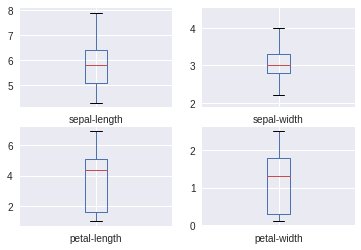

In [0]:
# box and whisker plots
dataset.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
plt.show()

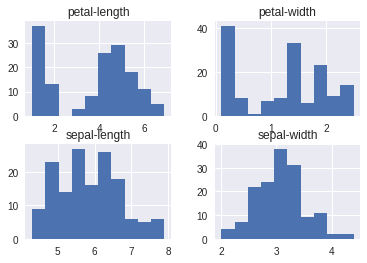

In [0]:


# histograms
dataset.hist()
plt.show()

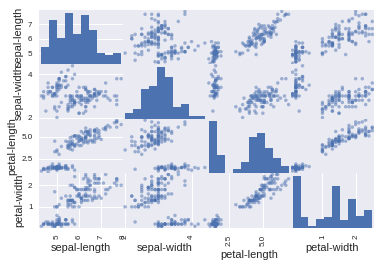

In [0]:
# scatter plot matrix
scatter_matrix(dataset)
plt.show()

In [0]:
# Split-out validation dataset
array = dataset.values
X = array[:,0:4]
Y = array[:,4]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [0]:

# Test options and evaluation metric
seed = 7
scoring = 'accuracy'

In [0]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LR: 0.966667 (0.040825)
LDA: 0.975000 (0.038188)
KNN: 0.983333 (0.033333)
CART: 0.975000 (0.038188)
NB: 0.975000 (0.053359)
SVM: 0.991667 (0.025000)


In [0]:
data_file = open("0000.jpg", "r")
training_data = data_file.readlines()
data_file.close()

# test_data_file = open("data/mnist_test.csv", "r")
# test_data = test_data_file.readlines()
# test_data_file.close()

UnicodeDecodeError: ignored

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 0015.jpg to 0015.jpg
Saving 0019.jpg to 0019.jpg
Saving 0025.jpg to 0025.jpg
Saving 0037.jpg to 0037.jpg
Saving 0046.jpg to 0046.jpg
Saving 0055.jpg to 0055.jpg
Saving 0064.jpg to 0064.jpg
Saving 0070.jpg to 0070.jpg
Saving 0082.jpg to 0082.jpg
Saving 0094.jpg to 0094.jpg
User uploaded file "0015.jpg" with length 8909 bytes
User uploaded file "0019.jpg" with length 11312 bytes
User uploaded file "0025.jpg" with length 6896 bytes
User uploaded file "0037.jpg" with length 13357 bytes
User uploaded file "0046.jpg" with length 5987 bytes
User uploaded file "0055.jpg" with length 13382 bytes
User uploaded file "0064.jpg" with length 68828 bytes
User uploaded file "0070.jpg" with length 25655 bytes
User uploaded file "0082.jpg" with length 57846 bytes
User uploaded file "0094.jpg" with length 13658 bytes


In [0]:
import tensorflow as tf
from PIL import Image
import numpy as np 

#Function to convert image to array or list 
def loadImage (inFileName, outType) : 
    img = Image.open(inFileName) 
    img.load() 
    data = np.asarray(img, dtype="int32") 
    if outType == "anArray": 
     return data 
    if outType == "aList": 
     return list(data) 

while(True):
    #Load image to array 
    Name=input()
    myArray1 = loadImage(Name, "anArray") 

    #Load image to a list 
    myList1 = loadImage(Name, "aList") 

    #print("Array::",myArray1,"\nList::",myList1[0])
    print("ArraySize:",len(myArray1[0]),"total size:",len(myArray1))
    t=tf.constant(myArray1)
    print(t.get_shape())
# 0094.jpg
# ArraySize: 275 total size: 183
# (183, 275, 3)
# 0015.jpg
# ArraySize: 275 total size: 183
# (183, 275, 3)
# 0019.jpg
# ArraySize: 318 total size: 159
# (159, 318, 3)
# 0025.jpg
# ArraySize: 255 total size: 198
# (198, 255, 3)
# 0037.jpg
# ArraySize: 275 total size: 183
# (183, 275, 3)
# 0045.jpg
# 0046.jpg
# ArraySize: 300 total size: 168
# (168, 300, 3)
# 0064.jpg
# ArraySize: 602 total size: 400
# (400, 602, 3)
# 0070.jpg
# ArraySize: 600 total size: 400
# (400, 600, 3)
# 0082.jpg
# ArraySize: 711 total size: 400
# (400, 711, 3)

0046.jpg
ArraySize: 300 total size: 168
(168, 300, 3)
0064.jpg
ArraySize: 602 total size: 400
(400, 602, 3)
0070.jpg
ArraySize: 600 total size: 400
(400, 600, 3)
0082.jpg
ArraySize: 711 total size: 400
(400, 711, 3)


KeyboardInterrupt: ignored

In [0]:
import matplotlib.pyplot as plt
import numpy as np
#s="".join(myArray1)
a=np.ndarray(shape=())
# t = np.asfarray(myArray1.slice(""))

# # 일렬로 늘어진 784개의 픽셀정보를 28x28 행렬로 바꾼다
# n = t[1:].reshape(12,12)

# plt.imshow(n, cmap='gray')
# plt.show()

SyntaxError: ignored

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# 필요한 라이브러리들을 임포트
import argparse
import sys

from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf

FLAGS = None


def deepnn(x):
  """숫자를 분류하기 위한 Deep Neural Networks 그래프를 생성한다.
  인자들(Args):
    x: (N_examples, 784) 차원을 가진 input tensor, 784 일반적인 MNIST 데이터의 픽셀 개수이다.
  리턴값들(Returns):
    tuple (y, keep_prob). y는 (N_examples, 10)형태의 숫자(0-9) tensor이다. 
    keep_prob는 dropout을 위한 scalar placeholder이다.
  """
  # Convolutional Neural Netwokrs(CNNs)를 위한 reshape.
  # 마지막 차원(dimension)은 특징들("features")을 나타낸다.-이 코드에서는 이미지가 grayscale이라 일차원이지만, RGB 이미지라면 3차원, RGBA라면 4차원 이미지 일 것이다.
  x_image = tf.reshape(x, [-1, 28, 28, 1])

  # 첫번째 convolutional layer - 하나의 grayscale 이미지를 32개의 특징들(feature)으로 맵핑(maping)한다.
  W_conv1 = weight_variable([5, 5, 1, 32])
  b_conv1 = bias_variable([32])
  h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

  # Pooling layer - 2X만큼 downsample한다.
  h_pool1 = max_pool_2x2(h_conv1)

  # 두번째 convolutional layer -- 32개의 특징들(feature)을 64개의 특징들(feature)로 맵핑(maping)한다.
  W_conv2 = weight_variable([5, 5, 32, 64])
  b_conv2 = bias_variable([64])
  h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

  # 두번째 pooling layer.
  h_pool2 = max_pool_2x2(h_conv2)

  # Fully Connected Layer 1 -- 2번의 downsampling 이후에, 우리의 28x28 이미지는 7x7x64 특징들(feature map)이 된다.
  # 이를 1024개의 특징들로 맵핑(maping)한다.
  W_fc1 = weight_variable([7 * 7 * 64, 1024])
  b_fc1 = bias_variable([1024])

  h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
  h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

  # Dropout - 모델의 복잡도를 컨트롤한다. 특징들의 co-adaptation을 방지한다.
  keep_prob = tf.placeholder(tf.float32)
  h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

  # 1024개의 특징들(feature)을 10개의 클래스-숫자 0-9-로 맵핑(maping)한다.
  W_fc2 = weight_variable([1024, 10])
  b_fc2 = bias_variable([10])

  y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
  return y_conv, keep_prob


def conv2d(x, W):
  """conv2d는 full stride를 가진 2d convolution layer를 반환(return)한다."""
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
  """max_pool_2x2는 특징들(feature map)을 2X만큼 downsample한다."""
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


def weight_variable(shape):
  """weight_variable는 주어진 shape에 대한 weight variable을 생성한다."""
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)


def bias_variable(shape):
  """bias_variable 주어진 shape에 대한 bias variable을 생성한다."""
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)


def main(_):
  # data를 import한다.
  mnist = input_data.read_data_sets(FLAGS.data_dir, one_hot=True)

  # 모델을 생성한다.
  x = tf.placeholder(tf.float32, [None, 784])

  # loss와 optimizer를 정의한다.
  y_ = tf.placeholder(tf.float32, [None, 10])

  # Deep Neural Networks 그래프를 생성한다.
  y_conv, keep_prob = deepnn(x)

  # Cross Entropy를 비용함수(loss function)으로 정의하고, AdamOptimizer를 이용해서 비용 함수를 최소화한다.
  cross_entropy = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
  train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
  
  # 정확도를 측정한다.
  correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(20000):
      batch = mnist.train.next_batch(50)
      # 100 Step마다 training 데이터셋에 대한 정확도를 출력한다.
      if i % 100 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x: batch[0], y_: batch[1], keep_prob: 1.0})
        print('step %d, training accuracy %g' % (i, train_accuracy))
      # 50% 확률의 Dropout을 이용해서 학습을 진행한다.
      train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

    # 테스트 데이터에 대한 정확도를 출력한다.
    print('test accuracy %g' % accuracy.eval(feed_dict={
                                                         x: mnist.test.images,
                                                         y_: mnist.test.labels, 
                                                         keep_prob: 1.0}))

if __name__ == '__main__':
  parser = argparse.ArgumentParser()
  parser.add_argument('--data_dir', type=str,
                      default='/tmp/tensorflow/mnist/input_data',
                      help='Directory for storing input data')
  FLAGS, unparsed = parser.parse_known_args()
  tf.app.run(main=main, argv=[sys.argv[0]] + unparsed)

In [0]:
##종이 자르기
def paper:
  N=input()
  minus=0
  plus=0
  zero=0
  while(True):
    a=input()
    if(N<9):
      
      for j in range(N):
        for i in range(N):
          if( a[j][i]==-1):
            minus++
            
          elseif(a[j][i]==0):
            zero++
          else:
            plus++
          
       
    else:
      b=a[0][0]
      while(b==a[i][j]):
        for i in range(N):
          for j in range(N):
            




      if(b!=a[i][])

    

In [0]:
##5로 12만들기
# 12 = 5 + 5 + (5 / 5) + (5 / 5)
# 12 = 55 / 5 + 5 / 5
# 12 = (55 + 5) / 5
def is_number(x):
  infix = input()
  postfix = []
  stack = []
  operator = ['*', '/', '+', '-']
  bracket = ['(', ')']

  if x not in operator and x not in bracket:
      return True
  else:
      return False
    
def pref(x):
    if x is '*' or x is '/':
        return 1
    elif x is '+' or x is '-':
        return 0
  for c in infix:
      if is_number(c):
          postfix.append(c)
      elif c in operator:
          p = pref(c)
          while len(stack) > 0:
              top = stack[-1]
              if pref(top) <= p:
                  break
              postfix.append(stack.pop())            
          stack.append(c)

      elif c == '(':
          stack.append(c)
      elif c == ')':
          while True:
              x = stack.pop()
              if x == '(':
                  break
              postfix.append(x)

  while len(stack) > 0:
      